Copyright 2023 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

## Setup

In [1]:
from ast import literal_eval
import functools
import json
import os
import random
import wget


# Scienfitic packages
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
torch.set_grad_enabled(False)
tqdm.pandas()

# Visuals
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(context="notebook", 
        rc={"font.size":16,
            "axes.titlesize":16,
            "axes.labelsize":16,
            "xtick.labelsize": 16.0,
            "ytick.labelsize": 16.0,
            "legend.fontsize": 16.0})
palette_ = sns.color_palette("Set1")
palette = palette_[2:5] + palette_[7:]
sns.set_theme(style='whitegrid')

# Utilities
from utils import (
    ModelAndTokenizer,
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_from_input,
)

# List of stopwords from NLTK, needed only for the attributes rate evaluation.
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords0_ = stopwords.words('english')
stopwords0_ = {word: "" for word in stopwords0_}

[nltk_data] Downloading package stopwords to /home/iustin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Get CounterFact data for GPT2-xl, from the ROME repository.
wget.download("https://rome.baulab.info/data/dsets/known_1000.json")
knowns_df = pd.read_json("known_1000.json")

# Load GPT2-xl from Huggingface.
model_name = "gpt2"
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=False,
    torch_dtype=None,
)
mt.model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

## Methods

In [4]:
def _split_heads(tensor, num_heads, attn_head_size):
    new_shape = tensor.size()[:-1] + (num_heads, attn_head_size)
    tensor = tensor.view(new_shape)
    return tensor.permute(1, 0, 2)  # (head, seq_length, head_features)

def _merge_heads(tensor, model):
    num_heads = model.config.n_head
    attn_head_size = model.config.n_embd // model.config.n_head
    
    tensor = tensor.permute(1, 0, 2).contiguous()
    new_shape = tensor.size()[:-2] + (num_heads * attn_head_size,)
    return tensor.view(new_shape)


def set_act_get_hooks(model, tok_index, attn=False, attn_out=False, mlp=False, mlp_coef=False):
    """
    Only works on GPT2
    """
    # Make sure that these are not set to True at the same time 
    #  so we don't put two different hooks on the same module.  
    assert not (attn is True and attn_out is True)
    
    for attr in ["activations_"]:
        if not hasattr(model, attr):
            setattr(model, attr, {})

    def get_activation(name):
        def hook(module, input, output):
            if "attn" in name:
                if "c_attn" in name:
                    # output.shape: batch_size, seq_len, 3 * hidden_dim
                    _, _, attn_value = output[0].split(model.config.n_embd, dim=1)
                    attn_value = _split_heads(attn_value,
                                              model.config.n_head, 
                                              model.config.n_embd // model.config.n_head)
                    model.activations_[name] = attn_value.detach()
                elif "attn_weights" in name:
                    assert len(output) == 3
                    attn_weights = output[2]  # (batch_size, num_heads, from_sequence_length, to_sequence_length)
                    # the last dimension is a distribution obtained from softmax
                    model.activations_[name] = attn_weights[0][:, tok_index, :].detach()
                else:
                    model.activations_[name] = output[0][:, tok_index].detach()
            elif "m_coef" in name:
                # num_tokens = list(input[0].size())[1]  # (batch, sequence, hidden_state)
                model.activations_[name] = input[0][:, tok_index].detach()
            elif "m_out" in name:
                model.activations_[name] = output[0][tok_index].detach()
        
        return hook

    hooks = []
    for i in range(model.config.n_layer):
        if attn is True:
            hooks.append(model.transformer.h[i].attn.c_attn.register_forward_hook(get_activation(f"c_attn_value_{i}")))
            hooks.append(model.transformer.h[i].attn.register_forward_hook(get_activation(f"attn_weights_{i}")))
        if attn_out is True:
            hooks.append(model.transformer.h[i].attn.register_forward_hook(get_activation(f"attn_out_{i}")))
        if mlp_coef is True:
            hooks.append(model.transformer.h[i].mlp.c_proj.register_forward_hook(get_activation("m_coef_" + str(i))))
        if mlp is True:
            hooks.append(model.transformer.h[i].mlp.register_forward_hook(get_activation("m_out_" + str(i))))
            
    return hooks


# To block attention edges, we zero-out entries in the attention mask.
# To do this, we add a wrapper around the attention module, because 
# the mask is passed as an additional argument, which could not be fetched 
# with standard hooks before pytorch 2.0.  
def set_block_attn_hooks(model, from_to_index_per_layer, opposite=False):
    """
    Only works on GPT2
    """
    def wrap_attn_forward(forward_fn, model_, from_to_index_, opposite_):
        @functools.wraps(forward_fn)
        def wrapper_fn(*args, **kwargs):
            new_args = []
            new_kwargs = {}
            for arg in args:
                new_args.append(arg)
            for (k, v) in kwargs.items():
                new_kwargs[k] = v

            hs = args[0]
            num_tokens = list(hs[0].size())[0]
            num_heads = model_.config.num_attention_heads
            
            if opposite_:
                attn_mask = torch.tril(torch.zeros((num_tokens, num_tokens), dtype=torch.uint8))
                for s, t in from_to_index_:
                    attn_mask[s, t] = 1
            else:
                attn_mask = torch.tril(torch.ones((num_tokens, num_tokens), dtype=torch.uint8))
                for s, t in from_to_index_:
                    attn_mask[s, t] = 0
            attn_mask = attn_mask.repeat(1, num_heads, 1, 1)
            
            attn_mask = attn_mask.to(dtype=model_.dtype)  # fp16 compatibility
            attn_mask = (1.0 - attn_mask) * torch.finfo(model_.dtype).min
            attn_mask = attn_mask.to(hs.device)

            new_kwargs["attention_mask"] = attn_mask
            
            return forward_fn(*new_args, **new_kwargs)

        return wrapper_fn
    
    hooks = []
    for i in from_to_index_per_layer.keys():
        hook = model.transformer.h[i].attn.forward
        model.transformer.h[i].attn.forward = wrap_attn_forward(model.transformer.h[i].attn.forward,
                                                                model, from_to_index_per_layer[i], opposite)
        hooks.append((i, hook))
    
    return hooks


def set_get_attn_proj_hooks(model, tok_index):
    """
    Only works on GPT2
    """
    for attr in ["projs_"]:
        if not hasattr(model, attr):
            setattr(model, attr, {})

    def get_projection(name, E):
        def hook(module, input, output):
            attn_out = output[0][:, tok_index]
            probs, preds = torch.max(
                torch.softmax(attn_out.matmul(E.T), dim=-1), 
                dim=-1
            )
            model.projs_[f"{name}_probs"] = probs.cpu().numpy()
            model.projs_[f"{name}_preds"] = preds.cpu().numpy()
            
        return hook

    E = model.get_input_embeddings().weight.detach()
    hooks = []
    for i in range(model.config.n_layer):
        hooks.append(model.transformer.h[i].attn.register_forward_hook(get_projection(f"attn_proj_{i}", E)))
            
    return hooks


def set_block_mlp_hooks(model, values_per_layer, coef_value=0):
    
    def change_values(values, coef_val):
        def hook(module, input, output):
            output[:, :, values] = coef_val

        return hook

    hooks = []
    for layer in range(model.config.n_layer):
        if layer in values_per_layer:
            values = values_per_layer[layer]
        else:
            values = []
        hooks.append(model.transformer.h[layer].mlp.c_fc.register_forward_hook(
            change_values(values, coef_value)
        ))

    return hooks


def set_proj_hooks(model):
    for attr in ["projs_"]:
        if not hasattr(model, attr):
            setattr(model, attr, {})

    def get_projection(name, E):
        def hook(module, input, output):
            num_tokens = list(input[0].size())[1]  #(batch, sequence, hidden_state)
            if name == f"layer_residual_{final_layer}":
                hs = output
            else:
                hs = input[0]
            probs, preds = torch.max(
                torch.softmax(hs.matmul(E.T), dim=-1), 
                dim=-1
            )
            model.projs_[f"{name}_preds"] = preds.cpu().numpy()
            model.projs_[f"{name}_probs"] = probs.cpu().numpy()
        return hook

    E = model.get_input_embeddings().weight.detach()
    final_layer = model.config.n_layer-1
    
    hooks = []
    for i in range(model.config.n_layer-1):
        hooks.append(model.transformer.h[i].register_forward_hook(
            get_projection(f"layer_residual_{i}", E)
        ))
    hooks.append(model.transformer.ln_f.register_forward_hook(
        get_projection(f"layer_residual_{final_layer}", E)
    ))

    return hooks


def set_hs_patch_hooks(model, hs_patch_config, patch_input=False):
    
    def patch_hs(name, position_hs, patch_input):
        
        def pre_hook(module, input):
            for position_, hs_ in position_hs:
                # (batch, sequence, hidden_state)
                input[0][0, position_] = hs_
        
        def post_hook(module, input, output):
            for position_, hs_ in position_hs:
                # (batch, sequence, hidden_state)
                output[0][0, position_] = hs_
        
        if patch_input:
            return pre_hook
        else:
            return post_hook

    hooks = []
    for i in hs_patch_config:
        if patch_input:
            hooks.append(model.transformer.h[i].register_forward_pre_hook(
                patch_hs(f"patch_hs_{i}", hs_patch_config[i], patch_input)
            ))
        else:
            hooks.append(model.transformer.h[i].register_forward_hook(
                patch_hs(f"patch_hs_{i}", hs_patch_config[i], patch_input)
            ))

    return hooks
    

# Always remove your hooks, otherwise things will get messy.
def remove_hooks(hooks):
    for hook in hooks:
        hook.remove()

def remove_wrapper(model, hooks):
    for i, hook in hooks:
        model.transformer.h[i].attn.forward = hook

In [5]:
def trace_with_attn_block(
    model,
    inp,
    from_to_index_per_layer,   # A list of (source index, target index) to block
    answers_t
):
    with torch.no_grad():
        # set hooks
        block_attn_hooks = set_block_attn_hooks(model, from_to_index_per_layer)
        
        # get prediction
        outputs_exp = model(**inp)
        
        # remove hooks
        remove_wrapper(model, block_attn_hooks)
    
    probs = torch.softmax(outputs_exp.logits[0, -1, :], dim=0)[answers_t]
    
    return probs


def trace_with_proj(model, inp):
    with torch.no_grad():
        # set hooks
        hooks = set_proj_hooks(model)
        
        # get prediction
        answer_t, base_score = [d[0] for d in predict_from_input(model, inp)]
        
        # remove hooks
        remove_hooks(hooks)
        
    projs = model.projs_
    
    return answer_t, base_score, projs


In [6]:
def intervene_on_info_flow(
    mt, prompt, source=None, kind="single", window=10, positions=None
):
    inp = make_inputs(mt.tokenizer, [prompt])
    answer_t, base_score, projs = trace_with_proj(mt.model, inp)
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    
    ntoks = inp["input_ids"].shape[1]
    if source is None:
        source_ = ntoks-1
    else:
        source_ = source
        
    if positions is None:
        positions = list(range(ntoks))
        
    table = []
    for tnum in positions:
        row = []
        for layer in range(mt.num_layers):
            if kind == "single":
                block_config = {layer: [(source_, tnum)]}
                r = trace_with_attn_block(
                    mt.model, inp, block_config, answer_t
                )
            elif kind == "window":
                layerlist = [
                    l for l in range(
                        max(0, layer - window // 2), min(mt.num_layers, layer - (-window // 2))
                    )
                ]
                block_config = {
                    l: [(source_, tnum)]
                    for l in layerlist
                }
                r = trace_with_attn_block(
                    mt.model, inp, block_config, answer_t
                )
            else:
                raise NotImplementedError
            row.append(r)
        table.append(torch.stack(row))
    differences = torch.stack(table)
    differences = differences.detach().cpu()
    
    low_score = differences.min()
    
    source_probs = [projs[f"layer_residual_{l}_probs"][0][source_] for l in range(mt.num_layers)]
    source_preds = decode_tokens(mt.tokenizer, 
                                 [projs[f"layer_residual_{l}_preds"][0][source_] for l in range(mt.num_layers)])
    
    return dict(
        scores=differences,
        source_probs=source_probs,
        source_preds=source_preds,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        answer=answer,
        source=source_,
        window=window,
        kind="",
    )



In [7]:
def plot_info_flow(
    mt,
    prompt,
    source=None,
    kind="single",
    window=10,
    set_lims=True,
    show_proj=True,
    savepdf=None,
):
    result = intervene_on_info_flow(mt, prompt, source, kind, window)
    
    differences = result["scores"]
    low_score = result["low_score"]
    answer = result["answer"]
    window = result.get("window", 10)
    source = result['source']
    labels = list(result["input_tokens"])
    labels[source] = labels[source] + "*"

    size_height = len(labels) * 0.3
    fig, ax = plt.subplots(figsize=(7, size_height), dpi=150)
    if set_lims:
        h = ax.pcolor(
            differences,
            cmap="Purples_r",
            vmin=0.0,
            vmax=1.0
        )
    else:
        h = ax.pcolor(
            differences,
            cmap="Purples_r",
        )
    ax.invert_yaxis()
    ax.set_yticks([0.5 + i for i in range(len(differences))])
    ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
    ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
    ax.set_yticklabels(labels)

    if show_proj:
        for x in range(mt.num_layers):
            plt.text(
                x + 0.5, source + 0.5, 
                f'{result["source_preds"][x]} {round(100.0 * result["source_probs"][x], 1)}',
                horizontalalignment='center', verticalalignment='center', rotation=90, fontsize=4,
            )

    cb = plt.colorbar(h)
    ax.set_title(
        f"Intervening on flow to: {result['input_tokens'][source]}\nwindow: {window}, base probability: {round(result['high_score'].cpu().numpy().item(), 4)}",
        fontsize=10
        )
    if answer is not None:
        cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=10)
    if savepdf:
        os.makedirs(os.path.dirname(savepdf), exist_ok=True)
        plt.savefig(savepdf, bbox_inches="tight")
        plt.close()
    else:
        plt.show()
    
    return result


## Information Flow Analysis

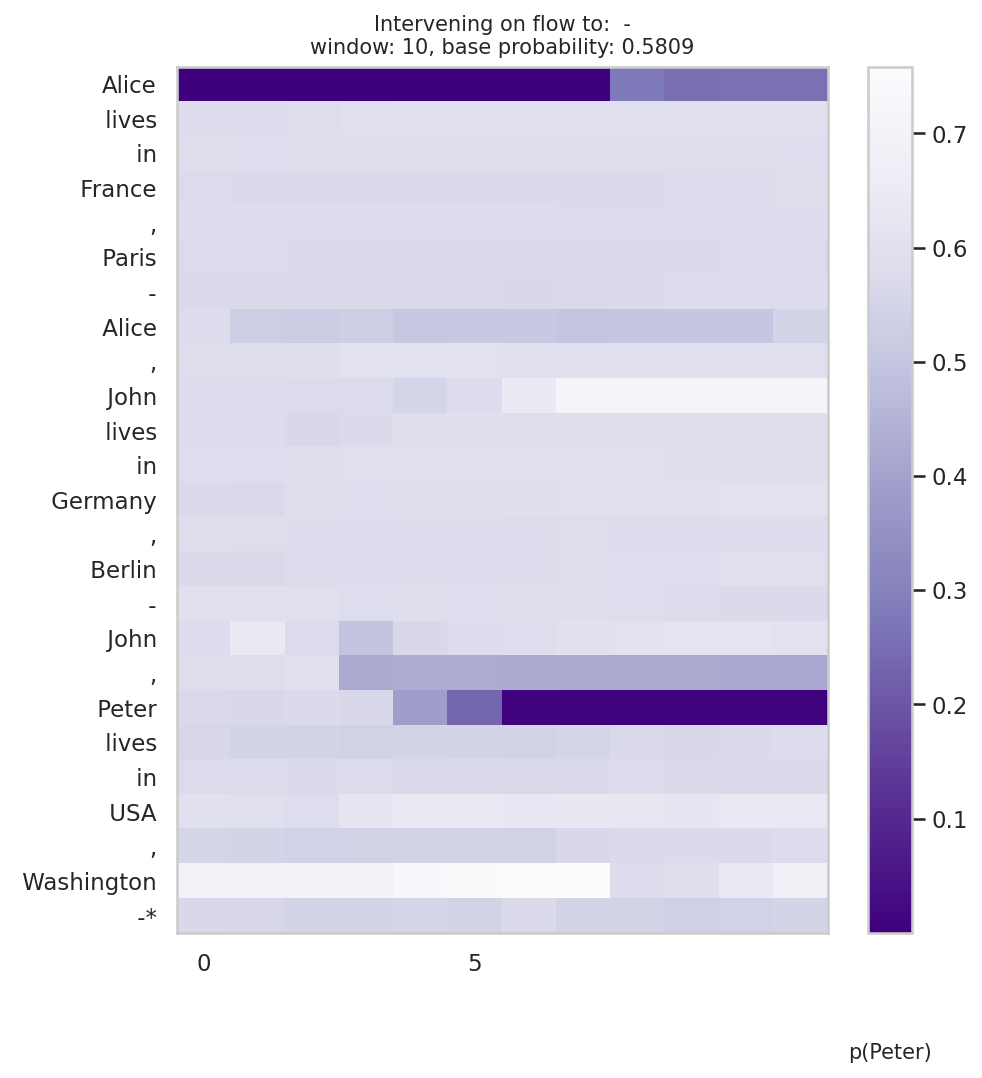

In [8]:
# Single-example interventions.

prompt = "Alice lives in France, Paris - Alice, John lives in Germany, Berlin - John, Peter lives in USA, Washington -"    
inp = make_inputs(mt.tokenizer, [prompt])
results = plot_info_flow(mt, prompt, source=None, kind="window", window=10, 
                         set_lims=False, show_proj=False,
                         # savepdf=f"figs/{prompt}.pdf"
                        )

1209it [04:58,  4.04it/s]


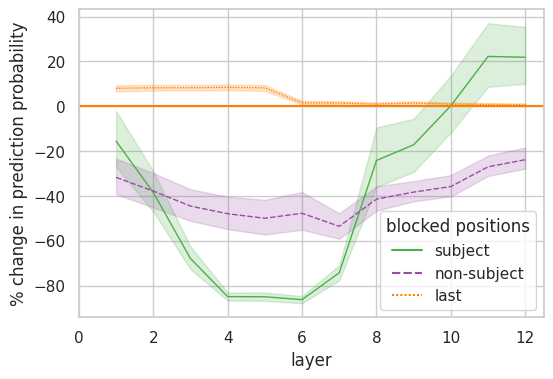

In [9]:
# Information flow analysis

window = 9

# Run attention knockouts
results = []
for row_i, row in tqdm(knowns_df.iterrows()):
    prompt = row.prompt
    subject = row.subject

    inp = make_inputs(mt.tokenizer, [prompt])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    e_range = [x for x in range(e_range[0], e_range[1])]

    answer_t, base_score, projs = trace_with_proj(mt.model, inp)
    base_score = base_score.cpu().item()
    [answer] = decode_tokens(mt.tokenizer, [answer_t])

    ntoks = inp["input_ids"].shape[1]
    source_ = ntoks-1

    for block_ids, block_desc in [
        ([x for x in e_range], "subject"),
        ([x for x in range(ntoks-1) if x not in e_range], "non-subject"),
        ([source_], "last"),
    ]:
        for layer in range(mt.num_layers):
            layerlist = [
                l for l in range(
                    max(0, layer - window // 2), min(mt.num_layers, layer - (-window // 2))
                )
            ]
            block_config = {
                l: [(source_, stok) for stok in block_ids]
                for l in layerlist
            }
            r = trace_with_attn_block(
                mt.model, inp, block_config, answer_t
            )
            new_score = r.cpu().item()
            results.append({
                "prompt": prompt,
                "block_desc": block_desc,
                "layer": layer,
                "base_score": base_score,
                "new_score": new_score,
                "relative diff": (new_score - base_score) * 100.0 / base_score,
                "is_subject_position_zero": e_range[0] == 0
            })

tmp = pd.DataFrame.from_records(results)
tmp["layer_1"] = tmp.layer.apply(lambda x: x+1)

# Plot the results
plt.figure(figsize=(6,4))
ax = sns.lineplot(tmp, x="layer_1", y="relative diff", 
                  hue="block_desc",
                  style="block_desc",
                  dashes=True,
                  palette=palette[:3], linewidth=1)
ax.set_xlabel("layer")
ax.set_ylabel("% change in prediction probability")
ax.set_xlim(0, mt.num_layers+0.5)
sns.move_legend(ax, "lower right", title="blocked positions")
plt.axhline(y=0, color=palette[2], linestyle='-')


## Cache of hidden representations

In [10]:
# create a cache of subject representations

layers_to_cache = list(range(mt.num_layers+1))
hs_cache = {}
for row_i, row in tqdm(knowns_df.iterrows()):
    prompt = row.prompt

    inp = make_inputs(mt.tokenizer, [prompt])
    output = mt.model(**inp, output_hidden_states = True)

    for layer in layers_to_cache:
        if (prompt, layer) not in hs_cache:
            hs_cache[(prompt, layer)] = []
        hs_cache[(prompt, layer)].append(output["hidden_states"][layer][0])
        
len(hs_cache)

1209it [00:04, 278.71it/s]


15704

In [11]:
# create a cache of subject representations

layers_to_cache = list(range(mt.num_layers))
subject_cache = {}
for row_i, row in tqdm(knowns_df.iterrows()):
    prompt = row.prompt
    subject = row.subject
    
    inp = make_inputs(mt.tokenizer, [prompt])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    e_range = [x for x in range(e_range[0], e_range[1])]
    
    output = mt.model(**inp, output_hidden_states = True)
    
    probs = torch.softmax(output["logits"][:, -1], dim=1)
    base_score, answer_t = torch.max(probs, dim=1)
    base_score = base_score.cpu().item()
    [answer] = decode_tokens(mt.tokenizer, answer_t)
    
    for layer in layers_to_cache:
        if (subject, layer) not in subject_cache:
            subject_cache[(subject, layer)] = []
        subject_cache[(subject, layer)].append(output["hidden_states"][layer+1][0, e_range[-1]])

len(subject_cache)

1209it [00:05, 240.50it/s]


14340

## Attribute extraction

1209it [11:47,  1.71it/s]


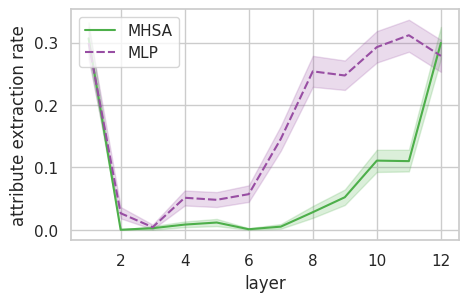

In [12]:

E = mt.model.get_input_embeddings().weight
k = 10

records = []
for row_i, row in tqdm(knowns_df.iterrows()):
    prompt = row.prompt
    subject = row.subject
    attribute = row.attribute
    
    inp = make_inputs(mt.tokenizer, [prompt])
    input_tokens = decode_tokens(mt.tokenizer, inp["input_ids"][0])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    e_range = [x for x in range(e_range[0], e_range[1])]
    non_e_range_last = [x for x in range(len(input_tokens)-1) if x not in e_range]
    source_index = len(input_tokens) - 1
    
    # set hooks to get ATTN and MLP outputs
    hooks = set_act_get_hooks(mt.model, source_index, mlp=True, attn_out=True)
    output = mt.model(**inp)
    # remove hooks
    remove_hooks(hooks)
    
    probs = torch.softmax(output["logits"][:, -1], dim=1)
    _, attribute_tok = torch.max(probs, dim=1)
    attribute_tok = attribute_tok.cpu().item()
    [attribute_tok_str] = decode_tokens(mt.tokenizer, [attribute_tok])
    
    for layer in range(mt.num_layers):
        # ATTN
        attn_out = mt.model.activations_[f'attn_out_{layer}'][0]
        proj = attn_out.matmul(E.T).cpu().numpy()
        ind = np.argsort(-proj, axis=-1)
        attribute_tok_rank = np.where(ind == attribute_tok)[0][0]
        attribute_tok_score = proj[ind[attribute_tok_rank]]
        top_k_preds = [decode_tokens(mt.tokenizer, [i])[0] for i in ind[:k]]
        records.append({
                "prompt": prompt,
                "subject": subject,
                "attribute": attribute,
                "attribute_tok": attribute_tok,
                "attribute_tok_str": attribute_tok_str,
                "layer": layer,
                "proj_vec": "MHSA",
                "top_k_preds": top_k_preds,
                "attribute_tok_rank": attribute_tok_rank,
                "attribute_tok_score": attribute_tok_score,
                "attribute_in_top_1": attribute_tok_rank == 0,
            })
        
        # MLP
        mlp_out = mt.model.activations_[f'm_out_{layer}']
        proj = mlp_out.matmul(E.T).cpu().numpy()
        ind = np.argsort(-proj, axis=-1)
        attribute_tok_rank = np.where(ind == attribute_tok)[0][0]
        attribute_tok_score = proj[ind[attribute_tok_rank]]
        top_k_preds = [decode_tokens(mt.tokenizer, [i])[0] for i in ind[:k]]
        records.append({
                "prompt": prompt,
                "subject": subject,
                "attribute": attribute,
                "attribute_tok": attribute_tok,
                "attribute_tok_str": attribute_tok_str,
                "layer": layer,
                "proj_vec": "MLP",
                "top_k_preds": top_k_preds,
                "attribute_tok_rank": attribute_tok_rank,
                "attribute_tok_score": attribute_tok_score,
                "attribute_in_top_1": attribute_tok_rank == 0,
            })
        
        
    # set hooks to get ATTN weights
    get_act_hooks = set_act_get_hooks(mt.model, source_index, attn=True)
    output = mt.model(**inp, output_attentions = True)
    # remove hooks
    remove_hooks(get_act_hooks)

    for layer in range(mt.num_layers):
        attn_c_proj = mt.model.transformer.h[layer].attn.c_proj
        val = mt.model.activations_[f'c_attn_value_{layer}']
        weight = mt.model.activations_[f'attn_weights_{layer}']
        
        weight = weight.unsqueeze(1)
        weight_block_subj = weight.detach().clone()
        for t in e_range:
            weight_block_subj[:, :, t] = -1e6
        weight_block_subj = torch.softmax(weight_block_subj, dim=-1)
        
        weight_block_subj_last = weight.detach().clone()
        weight_block_subj_last[:, :, e_range[-1]] = -1e6
        weight_block_subj_last = torch.softmax(weight_block_subj_last, dim=-1)
        
        weight_block_last = weight.detach().clone()
        weight_block_last[:, :, source_index] = -1e6
        weight_block_last = torch.softmax(weight_block_last, dim=-1)
        
        weight_block_subj_last_and_last = weight.detach().clone()
        weight_block_subj_last_and_last[:, :, e_range[-1]] = -1e6
        weight_block_subj_last_and_last[:, :, source_index] = -1e6
        weight_block_subj_last_and_last = torch.softmax(weight_block_subj_last_and_last, dim=-1)
        
        weight_block_nonsubj = weight.detach().clone()
        for t in non_e_range_last:
            weight_block_nonsubj[:, :, t] = -1e6
        weight_block_nonsubj[:, :, source_index] = -1e6
        weight_block_nonsubj = torch.softmax(weight_block_nonsubj, dim=-1)
        
        weight_block_nonsubj_but_last = weight.detach().clone()
        for t in non_e_range_last:
            weight_block_nonsubj_but_last[:, :, t] = -1e6
        weight_block_nonsubj_but_last = torch.softmax(weight_block_nonsubj_but_last, dim=-1)
        
        weight_block_all_but_first = torch.zeros_like(weight) -1e6
        weight_block_all_but_first[:, :, 0] = weight[:, :, 0]
        weight_block_all_but_first = torch.softmax(weight_block_all_but_first, dim=-1)
        
        weight_block_all_but_last = torch.zeros_like(weight) -1e6
        weight_block_all_but_last[:, :, source_index] = weight[:, :, source_index]
        weight_block_all_but_last = torch.softmax(weight_block_all_but_last, dim=-1)
        
        weight_block_all_but_subj_last = torch.zeros_like(weight) -1e6
        weight_block_all_but_subj_last[:, :, e_range[-1]] = weight[:, :, e_range[-1]]
        weight_block_all_but_subj_last = torch.softmax(weight_block_all_but_subj_last, dim=-1)
        
        weight_block_all_but_subj_last_last = torch.zeros_like(weight) -1e6
        weight_block_all_but_subj_last_last[:, :, e_range[-1]] = weight[:, :, e_range[-1]]
        weight_block_all_but_subj_last_last[:, :, source_index] = weight[:, :, source_index]
        weight_block_all_but_subj_last_last = torch.softmax(weight_block_all_but_subj_last_last, dim=-1)
        
        weight_block_all = torch.zeros_like(weight)
        
        for (weight_mat, weight_desc) in [
            (weight, "MHSA*"),
            (weight_block_subj, "MHSA block subject"),
            (weight_block_last, "MHSA block last"),
            (weight_block_subj_last, "MHSA block subject-last"),
            (weight_block_subj_last_and_last, "MHSA block subject-last + last"),
            (weight_block_nonsubj, "MHSA block non-subject"),
            (weight_block_nonsubj_but_last, "MHSA block non-subject ex. last"),
            (weight_block_all_but_first, "MSHA block all but first"),
            (weight_block_all_but_last, "MSHA block all but last"),
            (weight_block_all_but_subj_last, "MHSA block all but subject-last"),
            (weight_block_all_but_subj_last_last, "MHSA block all but subject-last + last"),
            (weight_block_all, "MHSA block all")
        ]:
            attn_out = torch.matmul(weight_mat, val)
            attn_out = _merge_heads(attn_out, mt.model)
            attn_out = torch.addmm(attn_c_proj.bias, attn_out, attn_c_proj.weight).squeeze()
            
            proj = attn_out.matmul(E.T).cpu().numpy()
            ind = np.argsort(-proj, axis=-1)
            attribute_tok_rank = np.where(ind == attribute_tok)[0][0]
            attribute_tok_score = proj[ind[attribute_tok_rank]]
            top_k_preds = [decode_tokens(mt.tokenizer, [i])[0] for i in ind[:k]]
            records.append({
                "prompt": prompt,
                "subject": subject,
                "attribute": attribute,
                "attribute_tok": attribute_tok,
                "attribute_tok_str": attribute_tok_str,
                "layer": layer,
                "proj_vec": weight_desc,
                "top_k_preds": top_k_preds,
                "attribute_tok_rank": attribute_tok_rank,
                "attribute_tok_score": attribute_tok_score,
                "attribute_in_top_1": attribute_tok_rank == 0,
            })


tmp = pd.DataFrame.from_records(records)
tmp["layer_1"] = tmp.layer.apply(lambda x: x+1)

# Plot the results
plt.figure(figsize=(5,3))
order = ["MHSA", "MLP"]
ax = sns.lineplot(
    x="layer_1", y="attribute_in_top_1",
    hue="proj_vec", style="proj_vec",
    hue_order=order, style_order = order,
    data=tmp[tmp.proj_vec.isin(order)],
    palette=palette[:2]
)
ax.legend_.set_title("")
ax.set_ylabel("attribute extraction rate")
ax.set_xlabel("layer")
sns.move_legend(ax, "upper left")


In [13]:
# Attribute extraction statistics: Per-example extraction rate (across layers).
# For how many examples there's at least one layer, where the attribute in the attention's output.

tmp_ = tmp[
    ["prompt", "proj_vec", "attribute_in_top_1"]
].groupby(["prompt", "proj_vec"]).agg("max").reset_index()

tmp_ [["proj_vec", "attribute_in_top_1"]
     ].groupby("proj_vec").agg("mean").reset_index().sort_values(by="attribute_in_top_1", ascending=False)

,proj_vec,attribute_in_top_1
0,MHSA,0.494205
10,MHSA*,0.494205
11,MLP,0.387417
8,MHSA block subject-last,0.346026
6,MHSA block non-subject ex. last,0.335265
9,MHSA block subject-last + last,0.334437
3,MHSA block all but subject-last + last,0.328642
4,MHSA block last,0.328642
7,MHSA block subject,0.313742
1,MHSA block all,0.301325


In [14]:
# Attribute extraction statistics: Number of extracting layers

# Averaging over examples with >=1 extraction events. 
tmp_ = tmp[
    ["prompt", "layer", "proj_vec", "attribute_in_top_1"]
].groupby(["prompt", "proj_vec", "attribute_in_top_1"]).agg("count").reset_index()
display(tmp_[tmp_.attribute_in_top_1 == True].groupby("proj_vec").agg("mean").reset_index())

# Averaging over all the examples.
tmp_ = tmp[
    ["prompt", "proj_vec", "attribute_in_top_1"]
].groupby(["prompt", "proj_vec"]).agg("sum").reset_index()
display(tmp_.groupby("proj_vec").agg("mean").reset_index())

,proj_vec,attribute_in_top_1,layer
0,MHSA,True,1.894472
1,MHSA block all,True,2.000000
2,MHSA block all but subject-last,True,1.376731
3,MHSA block all but subject-last + last,True,2.030227
4,MHSA block last,True,1.881612
5,MHSA block non-subject,True,1.307971
6,MHSA block non-subject ex. last,True,1.533333
7,MHSA block subject,True,2.253298
8,MHSA block subject-last,True,2.023923
9,MHSA block subject-last + last,True,1.747525


,proj_vec,attribute_in_top_1
0,MHSA,0.936258
1,MHSA block all,0.602649
2,MHSA block all but subject-last,0.411424
3,MHSA block all but subject-last + last,0.667219
4,MHSA block last,0.618377
5,MHSA block non-subject,0.298841
6,MHSA block non-subject ex. last,0.514073
7,MHSA block subject,0.706954
8,MHSA block subject-last,0.700331
9,MHSA block subject-last + last,0.584437


In [15]:
# Correlation between ATTN vs. MLP extraction events

tmp_ = tmp[tmp.proj_vec.isin(["MHSA", "MLP"])][
    ["prompt", "layer", "proj_vec", "attribute_in_top_1"]
].groupby(["prompt", "layer", "proj_vec"]).agg("max").reset_index()

tmp_ = tmp_.sort_values(by=["prompt", "layer", "proj_vec"])
tmp_ = tmp_.set_index(['prompt', 'layer', 'proj_vec'])['attribute_in_top_1'].unstack().reset_index()
tmp_ = tmp_.sort_values(by=["prompt", "layer"])

tmp_["MHSA"] = tmp_.apply(lambda row: int(row.MHSA) * (row.layer+1) - 1, axis=1)
tmp_["MLP"] = tmp_.apply(lambda row: int(row.MLP) * (row.layer+1) - 1, axis=1)
tmp_ = tmp_[["prompt", "MHSA", "MLP"]].groupby('prompt').agg(lambda x: [y for y in x.tolist() if y>-1]).reset_index()
tmp_["MHSA_first"] = tmp_.MHSA.apply(lambda x: min(x) if len(x) > 0 else -1)
tmp_["MLP_first"] = tmp_.MLP.apply(lambda x: min(x) if len(x) > 0 else -1)
tmp_["MHSA_ex"] = tmp_.MHSA.apply(lambda x: len(x) > 0)
tmp_["MLP_ex"] = tmp_.MLP.apply(lambda x: len(x) > 0)

print(len(tmp_))
print(tmp_[["MHSA_ex", "MLP_ex"]].value_counts() * 100.0 / len(tmp_))

tmp__ = tmp_[(tmp_.MHSA_ex == True) & (tmp_.MLP_ex == True)]
assert tmp__.MHSA_first.min() > -1
assert tmp__.MLP_first.min() > -1
tmp__["MHSA_before_MLP"] = tmp__.apply(lambda row: row.MHSA_first <= row.MLP_first, axis=1)
print(len(tmp__))
print(tmp__["MHSA_before_MLP"].value_counts() * 100.0 / len(tmp__))


1208
MHSA_ex  MLP_ex
False    False     43.708609
True     True      31.870861
         False     17.549669
False    True       6.870861
dtype: float64
385
True     97.662338
False     2.337662
Name: MHSA_before_MLP, dtype: float64


/home/iustin/.conda/envs/dissecting-paper/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
# Attribute extraction rate with patching of early representations

E = mt.model.get_input_embeddings().weight
k = 10

records = []
for row_i, row in tqdm(knowns_df.iterrows()):
    prompt = row.prompt
    subject = row.subject
    attribute = row.attribute
    
    inp = make_inputs(mt.tokenizer, [prompt])
    input_tokens = decode_tokens(mt.tokenizer, inp["input_ids"][0])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    e_range = [x for x in range(e_range[0], e_range[1])]
    non_e_range = [x for x in range(len(input_tokens)-1) if x not in e_range]
    source_index = len(input_tokens) - 1

    # set hooks to get ATTN outputs
    hooks = set_act_get_hooks(mt.model, source_index, attn_out=True)
    
    output = mt.model(**inp)
    probs = torch.softmax(output["logits"][:, -1], dim=1)
    _, attribute_tok = torch.max(probs, dim=1)
    attribute_tok = attribute_tok.cpu().item()
    [attribute_tok_str] = decode_tokens(mt.tokenizer, [attribute_tok])
    
    activations = {key: val for key, val in mt.model.activations_.items()}
    mt.model.activations_ = {}
    

    for layer in range(mt.num_layers):
        # ATTN
        attn_out = activations[f'attn_out_{layer}'][0]
        proj = attn_out.matmul(E.T).cpu().numpy()
        ind = np.argsort(-proj, axis=-1)
        attribute_tok_rank = np.where(ind == attribute_tok)[0][0]
        attribute_tok_score = proj[ind[attribute_tok_rank]]
        top_k_preds = [decode_tokens(mt.tokenizer, [i])[0] for i in ind[:k]]
        records.append({
            "prompt": prompt,
            "subject": subject,
            "attribute": attribute,
            "attribute_tok": attribute_tok,
            "attribute_tok_str": attribute_tok_str,
            "layer": layer,
            "proj_vec": "attn",
            "top_k_preds": top_k_preds,
            "attribute_tok_rank": attribute_tok_rank,
            "attribute_tok_score": attribute_tok_score,
            "attribute_in_top_1": attribute_tok_rank == 0,
            "patch_desc": "-",
            "patch_layer": "-",
        })

        # ATTN over patched subject representations
        for patch_positions, patch_desc in [(e_range, "subject"),
                                            (non_e_range, "non-subject"),
                                            ([source_index], "last")]:
            for layer_ in [0, 1, 5, 10, 20]:
                # set hooks to patch early hidden states
                hs_patch_config = {
                    layer: [
                        (i, hs_cache[(prompt, layer_)][0][i])
                        for i in patch_positions
                    ]
                }
                patch_hooks = set_hs_patch_hooks(mt.model, hs_patch_config, patch_input=True)

                # run model on the same prompt
                _ = mt.model(**inp)

                # remove patching hooks
                remove_hooks(patch_hooks)

                attn_out = mt.model.activations_[f'attn_out_{layer}'][0]
                proj = attn_out.matmul(E.T).cpu().numpy()
                ind = np.argsort(-proj, axis=-1)
                attribute_tok_rank = np.where(ind == attribute_tok)[0][0]
                attribute_tok_score = proj[ind[attribute_tok_rank]]
                top_k_preds = [decode_tokens(mt.tokenizer, [i])[0] for i in ind[:k]]
                records.append({
                    "prompt": prompt,
                    "subject": subject,
                    "attribute": attribute,
                    "attribute_tok": attribute_tok,
                    "attribute_tok_str": attribute_tok_str,
                    "layer": layer,
                    "proj_vec": "attn",
                    "top_k_preds": top_k_preds,
                    "attribute_tok_rank": attribute_tok_rank,
                    "attribute_tok_score": attribute_tok_score,
                    "attribute_in_top_1": attribute_tok_rank == 0,
                    "patch_desc": patch_desc,
                    "patch_layer": str(layer_),
                })
                mt.model.activations_ = {}

    # remove hooks
    remove_hooks(hooks)

tmp = pd.DataFrame.from_records(records)

0it [00:00, ?it/s]


KeyError: ('Vinson Massif is located in the continent of', 20)

In [17]:

tmp_ = tmp[
    ["prompt", "patch_layer", "patch_desc", "attribute_in_top_1"]
].groupby(["prompt", "patch_desc", "patch_layer"]).agg("max").reset_index()
tmp__ = tmp_[["patch_layer", "patch_desc", "attribute_in_top_1"]].groupby(
    ["patch_layer", "patch_desc"]).agg("mean").reset_index()

tmp__["patch_layer_int"] = tmp__.patch_layer.apply(lambda x: literal_eval(x) if x != "-" else -1)


plt.figure(figsize=(4.5,2.5))
order = ["subject", "non-subject", "last"]
ax = sns.scatterplot(
    x="patch_layer_int", 
    y=f"attribute_in_top_1",
    hue="patch_desc", style="patch_desc",
    hue_order=order, style_order=order,
    data=tmp__[tmp__.patch_layer != "-"],
    palette=palette[:3],
    s=100
)
ax.set_xlabel("layer used for patching")
ax.set_ylabel(f"attribute extraction rate")
sns.move_legend(ax, "lower right", title="patched positions", bbox_to_anchor=(1.01, -0.01), ncol=1)

no_patch_mean = tmp__[tmp__.patch_layer == "-"]["attribute_in_top_1"].mean()
plt.axhline(y=no_patch_mean, color=palette[4], linestyle='-', linewidth=1)


KeyError: "['patch_layer', 'patch_desc'] not in index"

In [18]:

# Comparing the attribute rank in the subject representation and in the attention output

E = mt.model.get_input_embeddings().weight

records = []
for row_i, row in tqdm(knowns_df.iterrows()):
    prompt = row.prompt
    subject = row.subject
    attribute = row.attribute
    
    inp = make_inputs(mt.tokenizer, [prompt])
    output = mt.model(**inp)
    probs = torch.softmax(output["logits"][:, -1], dim=1)
    _, attribute_tok = torch.max(probs, dim=1)
    attribute_tok = attribute_tok.cpu().item()
    [attribute_tok_str] = decode_tokens(mt.tokenizer, [attribute_tok])
    
    input_tokens = decode_tokens(mt.tokenizer, inp["input_ids"][0])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    e_range = [x for x in range(e_range[0], e_range[1])]
    source_index = len(input_tokens) - 1
    
    # set hooks to get ATTN and MLP outputs
    hooks = set_act_get_hooks(mt.model, source_index, mlp=True, attn_out=True)
    output = mt.model(**inp)
    # remove hooks
    remove_hooks(hooks)
    
    for layer in range(mt.num_layers):
        attn_out = mt.model.activations_[f'attn_out_{layer}'][0]
        proj_attn = attn_out.matmul(E.T).cpu().numpy()
        ind_attn = np.argsort(-proj_attn, axis=-1)
        attribute_tok_rank_attn = np.where(ind_attn == attribute_tok)[0][0]
        
        subj_hs = subject_cache[(subject, layer)][0]
        proj_hs = subj_hs.matmul(E.T).cpu().numpy()
        ind_hs = np.argsort(-proj_hs, axis=-1)
        attribute_tok_rank_hs = np.where(ind_hs == attribute_tok)[0][0]
        attribute_tok_rank_diff = attribute_tok_rank_hs - attribute_tok_rank_attn
        
        records.append({
            "prompt": prompt,
            "subject": subject,
            "attribute": attribute,
            "attribute_tok": attribute_tok,
            "attribute_tok_str": attribute_tok_str,
            "layer": layer,
            "attribute_tok_rank_attn": attribute_tok_rank_attn,
            "attribute_tok_rank_hs": attribute_tok_rank_hs,
            "attribute_tok_rank_diff": attribute_tok_rank_diff,
            "attribute_in_top_1_attn": attribute_tok == ind_attn[0],
            "attribute_in_top_1_hs": attribute_tok == ind_hs[0],
            })
        
tmp = pd.DataFrame.from_records(records)
print(tmp[tmp[f"attribute_in_top_1_attn"] == True]["attribute_tok_rank_diff"].describe())

1it [00:00,  9.73it/s]


IndexError: index 9 is out of bounds for dimension 1 with size 6

## Subject enrichment

### Get token representations' projections

In [19]:
E = mt.model.get_input_embeddings().weight.detach()
k = 500

In [20]:
# Projection of token representations

records = []
for row_i, row in tqdm(knowns_df.iterrows()):
    prompt = row.prompt
    subject = row.subject
    
    inp = make_inputs(mt.tokenizer, [prompt])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    e_range = [x for x in range(e_range[0], e_range[1])]
    
    for layer in range(mt.num_layers):
        positions = [(0, f"first_token_{layer+1}"),
                     (e_range[-1], f"subj_last_{layer+1}"),
                     (e_range[0], f"subj_first_{layer+1}"),
                     (e_range[-1]+1, f"no_subj_follow_{layer+1}"),
                     (len(inp["input_ids"][0])-1, f"no_subj_last_{layer+1}")]
        for (position, desc) in positions:
            hs = hs_cache[(prompt, layer)][0][position]
            projs = hs.matmul(E.T).cpu().numpy()
            ind = np.argsort(-projs)

            records.append({
                "example_index": row_i,
                "subject": subject,
                "layer": layer,
                "position": position,
                "desc": desc,
                "desc_short": desc.rsplit("_", 1)[0],
                "top_k_preds": [decode_tokens(mt.tokenizer, [i])[0] for i in ind[:k]],
            })

tmp = pd.DataFrame.from_records(records)

1209it [06:11,  3.26it/s]


In [21]:
# Projection of token embeddings

records = []
for row_i, row in tqdm(knowns_df.iterrows()):
    subject = row.subject
    prompt = row.prompt
    prompt = "<|endoftext|> " + prompt  # fix first-position bias
    
    inp = make_inputs(mt.tokenizer, [prompt])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    e_range = [x for x in range(e_range[0], e_range[1])]
    subject_tok = [inp["input_ids"][0][i].item() for i in e_range]
    subject_tok_str = [decode_tokens(mt.tokenizer, [t])[0] for t in subject_tok]
    
    vec = E[subject_tok, :].mean(axis=0)
    proj = vec.matmul(E.T).cpu().numpy()
    ind = np.argsort(-proj)
    record = {
        "example_index": row_i,
        "prompt": row.prompt,
        "subject": subject,
        "subject_tok": subject_tok,
        "subject_tok_str": str(subject_tok_str),
        "top_k_preds_str": [decode_tokens(mt.tokenizer, [t])[0] for t in ind[:k]],
    }
    records.append(record)

tmp = pd.DataFrame.from_records(records)

1209it [00:07, 172.68it/s]


In [32]:
# Projection of token representations while applying knockouts to MHSA/MLP sublayers

all_mlp_dims = list(range(mt.model.config.n_embd * 4))
subject_repr_layer = 40
num_block_layers = 10

records = []
for row_i, row in tqdm(knowns_df.iterrows()):
    prompt = row.prompt
    subject = row.subject
    inp = make_inputs(mt.tokenizer, [prompt])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    e_range = [x for x in range(e_range[0], e_range[1])]
    position = e_range[-1]
    
    output_ = mt.model(**inp, output_hidden_states = True)
    hs_ = output_["hidden_states"][subject_repr_layer+1][0, position]
    projs_ = hs_.matmul(E.T).cpu().numpy()
    ind_ = np.argsort(-projs_)
    top_k_preds_ = [decode_tokens(mt.tokenizer, [i])[0] for i in ind_[:k]]
    
    for start_block_layer in range(subject_repr_layer):
        records.append({
            "example_index": row_i,
            "subject": subject,
            "layer": subject_repr_layer,
            "position": position,
            "block_layers": [],
            "block_module": "None",
            "start_block_layer": start_block_layer,
            "end_block_layer": -1,
            "num_block_layers": 0,
            "num_block_layers_": 0,
            "top_k_preds": top_k_preds_
        })
        
        end_block_layer = min(start_block_layer + num_block_layers + 1, subject_repr_layer)
        block_layers = [l for l in range(start_block_layer, end_block_layer)]
        for block_module in ["mlp", "attn"]:
            with torch.no_grad():
                if block_module == "mlp":
                    block_config = {layer_: all_mlp_dims for layer_ in block_layers}
                    block_mlp_hooks = set_block_mlp_hooks(mt.model, block_config)
                    output = mt.model(**inp, output_hidden_states = True)
                    remove_hooks(block_mlp_hooks)
                elif block_module == "attn":
                    block_config = {layer_: [] for layer_ in block_layers}
                    block_attn_hooks = set_block_attn_hooks(mt.model, block_config, opposite=True)
                    output = mt.model(**inp, output_hidden_states = True)
                    remove_wrapper(mt.model, block_attn_hooks)

            hs = output["hidden_states"][subject_repr_layer+1][0, position]
            projs = hs.matmul(E.T).cpu().numpy()
            ind = np.argsort(-projs)

            records.append({
                "example_index": row_i,
                "subject": subject,
                "layer": subject_repr_layer,
                "position": position,
                "block_layers": block_layers,
                "block_module": block_module,
                "start_block_layer": start_block_layer,
                "end_block_layer": end_block_layer-1,
                "num_block_layers": num_block_layers,
                "num_block_layers_": len(block_layers),
                "top_k_preds": [decode_tokens(mt.tokenizer, [i])[0] for i in ind[:k]]
            })

tmp = pd.DataFrame.from_records(records)

0it [00:00, ?it/s]


IndexError: tuple index out of range

: 

### Prepare attributes rate evaluation

In [23]:
# Processing of Wikipedia paragraphs for automatic attribute rate evaluation.

# This should be a path to a csv file with 2 columns and a header of column names "subject" and "paragraphs".
# Each entry should have (a) a subject (string) from the "knowns" data (knowns_df) 
# and (b) paragraphs concatenated with space about the subject (a single string).
paragraphs_data_path = None
df_wiki = pd.read_csv(paragraphs_data_path)

# Tokenize, remove duplicate tokens, stopwords, and subwords. 
df_wiki["context_tokenized_dedup"] = df_wiki["paragraphs"].progress_apply(
    lambda x: list(set(decode_tokens(mt.tokenizer, mt.tokenizer([x])['input_ids'][0])))
)
df_wiki["context_tokenized_dedup_len"] = df_wiki.context_tokenized_dedup.apply(lambda x: len(x))

df_wiki["context_tokenized_dedup_no-stopwords"] = df_wiki.context_tokenized_dedup.apply(
    lambda x: [
        y for y in x 
        if y.strip() not in stopwords0_ and len(y.strip())>2
    ]
)
df_wiki["context_tokenized_dedup_no-stopwords_len"] = df_wiki["context_tokenized_dedup_no-stopwords"].apply(
    lambda x: len(x))

ValueError: Invalid file path or buffer object type: <class 'NoneType'>

In [24]:
def get_preds_wiki_overlap(subject, top_preds):
    wiki_toks = df_wiki[df_wiki.subject == subject]
    if len(wiki_toks) == 0:
        return -1
    wiki_toks = wiki_toks.iloc[0]["context_tokenized_dedup_no-stopwords"]
    preds_wiki_inter = set(top_preds).intersection(set(wiki_toks))
    
    return len(preds_wiki_inter) * 100.0 / len(top_preds)

### Evaluate attributes rate

In [25]:
tmp["top_k_preds_clean"] = tmp.top_k_preds.progress_apply(lambda x: [
    y for y in x 
    if y.strip().lower() not in stopwords0_ and len(y.strip())>2
])
tmp["num_clean_tokens"] = tmp.top_k_preds_clean.progress_apply(lambda x: len(x))

AttributeError: 'DataFrame' object has no attribute 'top_k_preds'

In [26]:
m = 50  # evaluate the 50 top-scoring tokens
tmp["top_k_preds_in_context"] = tmp.progress_apply(
    lambda row: get_preds_wiki_overlap(row["subject"], row["top_k_preds_clean"][:m]), 
    axis=1
    )
print(len(tmp[tmp.top_k_preds_in_context == -1]) * 100.0 / len(tmp))
print(tmp[tmp.top_k_preds_in_context > -1].subject.nunique())

  0%|          | 1/1209 [00:00<00:01, 1186.17it/s]


KeyError: 'top_k_preds_clean'

In [27]:
# Plot the attributes rate at different positions across layers 

tmp["desc_short_"] = tmp.desc_short.apply(
    lambda x: {"subj_first": "subject first", 
               "subj_last": "subject last", 
               "no_subj_follow": "subject subseq.", 
               "no_subj_last": "input last",
               "first_token": "input first"}[x]
    )
tmp["layer_1"] = tmp.layer.apply(lambda x: x+1)
order = ["subject last", "subject first", "subject subseq.", "input last"]

plt.figure(figsize=(5,3))
ax = sns.lineplot(data=tmp[tmp.top_k_preds_in_context > -1], 
                 x="layer_1", y="top_k_preds_in_context", hue="desc_short_",
                style="desc_short_",
                dashes=True,
                linewidth=2,
                markers=False,
                palette=palette[:4],
                hue_order=order,
                style_order=order
                 )
ax.set_xlabel("layer")
ax.set_ylabel(f"attributes rate")
sns.move_legend(ax, "upper left", title="", 
                labelspacing=0.3, handlelength=1.0, handletextpad=0.5)


AttributeError: 'DataFrame' object has no attribute 'desc_short'

In [28]:
# Plot the change in the attributes rate in the subject representation at a specific layer,
#  when knocking out different MLP/MHSA sublayers

subject_repr_layer = 40

tmp["desc_short"] = tmp[['block_module', 'num_block_layers']].apply(tuple, axis=1)
tmp["desc_short_"] = tmp.desc_short.apply(
    lambda x: {'mlp': "MLP sublayers", 
               'attn': "MHSA sublayers", 
               'None': "No intervention"}[x[0]]
    )
tmp["start_block_layer_1"] = tmp.start_block_layer.apply(lambda x: x+1)

plt.figure(figsize=(4,2))
tmp_ = tmp[(tmp.top_k_preds_in_context > -1) & (tmp.num_block_layers.isin([0, 10]))]
ax = sns.lineplot(data=tmp_, 
                  x="start_block_layer", y="top_k_preds_in_context", 
                  hue="desc_short_",
                  style="desc_short_",
                  palette=palette[:3],
                  dashes=True,
                  linewidth=2,
                  markers=False
                 )
ax.legend_.set_title("")
ax.set_ylabel(f"attributes rate\nat layer {subject_repr_layer}")
ax.set_xlabel("intervention layers")

KeyError: "None of [Index(['block_module', 'num_block_layers'], dtype='object')] are in the [columns]"